# CNN Cancer Detection Kaggle Mini-Project

DTSA 5511: Introduction to Deep Learning

Andrew Simms (University of Colorado Boulder)  
2024-11-24

# 1. Problem Description

The [Histopathologic Cancer Detection Kaggle
competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)
developed by Cukierski (2018) details a challenge in medical
diagnostics: identifying metastatic cancer in small image patches
extracted from larger digital pathology scans. This binary
classification problem involves determining whether each image patch
contains cancerous or non-cancerous tissue. The competition utilizes a
modified version of the PatchCamelyon (PCam) dataset, a well-established
benchmark in medical imaging, providing labeled image patches that
facilitate the development and evaluation of image classification
models.

This report aims to quantify the impact of architectural configurations
and preprocessing strategies on model accuracy, employing common
performance metrics and visualization techniques to analyze results.
Ultimately, this work seeks to understand the application of CNNs in
pathology image analysis and their potential contributions to automated
cancer detection.

## 1.1 Approach & Methodology

At a high level, this project aims to train, validate, and test
different CNN architectures, as introduced in the Week 3 lectures:

-   VGNet, defined in
    <a href="#lst-vgnet" class="quarto-xref">Listing 1</a>, based on
    *Very Deep Convolutional Networks for Large-Scale Image Recognition*
    (Simonyan and Zisserman 2015)  
-   InceptionNet, defined in
    <a href="#lst-inception" class="quarto-xref">Listing 2</a>, based on
    *Going Deeper With Convolutions* (Szegedy et al. 2014)  
-   ResNet, defined in
    <a href="#lst-resnet" class="quarto-xref">Listing 3</a>, based on
    *Deep Residual Learning for Image Recognition* (He et al. 2015)

The training methodology will follow an iterative procedure: defining
models, training them on labeled image patches, evaluating their
performance on test data, and refining them through hyperparameter
optimization. The cycle repeats to improve performance, offering a
systematic approach to model development.

<figure id="fig-train-high-level">
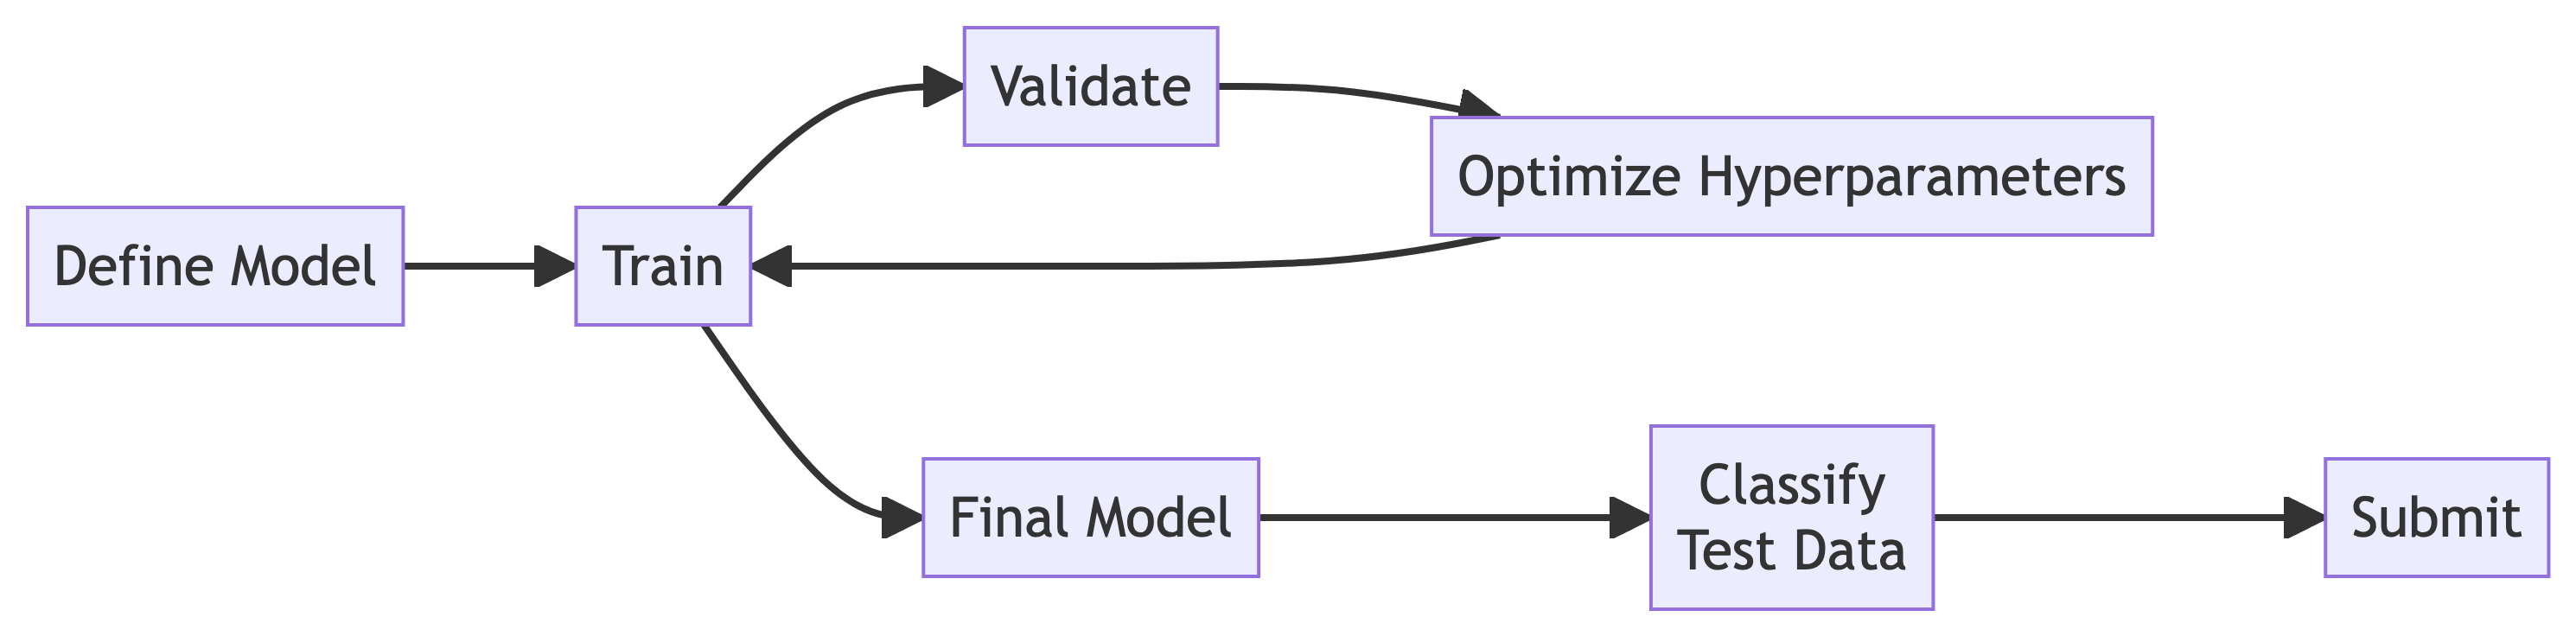
<figcaption>Figure 1: High Level Project Flowchart</figcaption>
</figure>

This cyclical workflow defines a structured exploration of CNN
performance, with a particular emphasis on targeted hyperparameter
optimization of initial models. Given the extensive range of
hyperparameters that can be adjusted, which could potentially lead to an
ongoing and open-ended process, we will focus on a carefully selected
subset of hyperparameters. These will be identified based on insights
gained from exploratory data analysis conducted prior to bulk model
training. This focused approach not only aims to develop high-performing
models but also to uncover valuable insights into the complex
relationships between model architecture, data characteristics, and
predictive outcomes.

## 1.2 Data Descriptions

There are 3 data products necessary for training a CNN, training images,
training classifications, and test images to classify. In the sections
below we detail each of these distinct datasets.

In [1]:
from pathlib import Path
import seaborn as sns
sns.set_theme()

train_img_path = Path("../data/cancer_detection/histopathologic-cancer-detection/train")
test_img_path = Path("../data/cancer_detection/histopathologic-cancer-detection/test")

### 1.2.1 Training Data

| Statistic   |                                      Value |
|:------------|-------------------------------------------:|
| Format      | 96 x 96 px `.tif` images in `train` folder |
| Value Count |                                     220025 |

Table 1: Training Data Statistics

### 1.2.2 Training Labels

In [2]:
import pandas as pd


df = pd.read_csv("../data/cancer_detection/histopathologic-cancer-detection/train_labels.csv")

| Statistic     |                              Value |
|:--------------|-----------------------------------:|
| Format        | Tabular Data in `train_labels.csv` |
| Value Count   |                             220025 |
| Columns       |                  \[‘id’, ‘label’\] |
| `NaN` Count   |                                  0 |
| Unique Values |                               0, 1 |

Table 2: Training Labels Statistics

### 1.2.3 Test Data

| Statistic   |                                     Value |
|:------------|------------------------------------------:|
| Format      | 96 x 96 px `.tif` images in `test` folder |
| Value Count |                                     57458 |

Table 3: Testing Data Statistics

## 1.3 Expected Output

The Kaggle submission expects an output csv file called `submission.csv`
with the columns:

| Column  |                                       Content |
|:--------|----------------------------------------------:|
| `id`    |               Input image name without `.tif` |
| `label` | Classification, 0 for no cancer, 1 for cancer |

Table 4: Kaggle Submission Data Description

# 2. Exploratory Data Analysis

## 2.1 Training Data Classifications

Training data is provided in two forms, `.tif` images and a csv file
mapping `.tif` images to labels. Parsing `train_labels.csv` yield
specifications about the training dataset:

In [3]:
from IPython.display import Markdown, display


display(Markdown(df.head().to_markdown(index=False)))

In <a href="#tbl-train-head" class="quarto-xref">Table 5</a> the column
`id` maps to a `.tif` file in the `train` folder and the `label`
indicates if the images is classified as having cancer, `1` or not
having cancer, `0`

### 2.1.1 Training Label Statistics

| Statistic         | Value    |
|-------------------|----------|
| Value Count       | 220025   |
| `NaN` Count       | 0        |
| Unique Values     | 0, 1     |
| Percentage of `1` | 40.5031% |
| Percentage of `0` | 59.4969% |

Table 6: Training Label Data Statistics

In <a href="#tbl-train-label-stats" class="quarto-xref">Table 6</a>
there we calculate that roughly 40 percent of the training data has a
training label of 1. While not entirely unexpected, this is interesting
and may be useful as a secondary validation check during the training
process

## 2.2 Training Images

In <a href="#fig-train-images-sample" class="quarto-xref">Figure 2</a>
the first 5 images in the dataset are visualized at their full
resolution. Per the Kaggle data description the images are 96x96px, but
the classification was done within the 32x32px section.

``` python
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image


img_labels = df['id'].iloc[:5].to_list()

def plot_cancer_images(img_labels, zoom=False, scale_factor=1):
    for img in img_labels:
        img_path = Path(train_img_path, f"{img}.tif")
        with Image.open(img_path) as img:
            if zoom:
                # Crop to the center 32x32 pixels
                width, height = img.size
                left = (width - 32) // 2
                top = (height - 32) // 2
                right = left + 32
                bottom = top + 32
                img = img.crop((left, top, right, bottom))
            
            # Get the new image size
            width, height = img.size
            
            # Apply scale factor if zoomed
            width *= scale_factor
            height *= scale_factor
            
            # Set figure size to match the scaled image size
            dpi = 100  # Dots per inch
            figsize = (width / dpi, height / dpi)
            
            # Create figure and axes
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
            ax.imshow(img)
            ax.axis("off")  # Turn off axes
            
            # Remove all margins and display inline
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            plt.show()

plot_cancer_images(img_labels)
```

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-1">
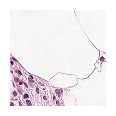
<figcaption>(a)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-2">
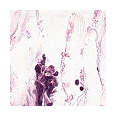
<figcaption>(b)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-3">
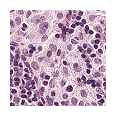
<figcaption>(c)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-4">
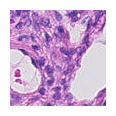
<figcaption>(d)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-5">
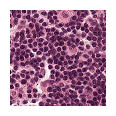
<figcaption>(e)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 2: Sample of Training Images

### 2.2.1 Full Size Image Comparison

A comparison of full size positive and negatives is shown in
<a href="#fig-train-images-sample-positive"
class="quarto-xref">Figure 3</a> and
<a href="#fig-train-images-sample-negative"
class="quarto-xref">Figure 4</a>. The purpose of this visualization is
to determine if there are obvious visual differences between the two
image classes.

#### 2.2.1.1 Positive Sample Images

``` python
positive_labels = df.loc[df['label'] == 1, 'id'].iloc[:25].to_list()
plot_cancer_images(positive_labels)
```

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-1">
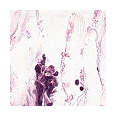
<figcaption>(a)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-2">
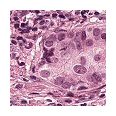
<figcaption>(b)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-3">
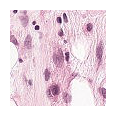
<figcaption>(c)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-4">
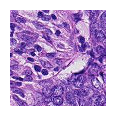
<figcaption>(d)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-5">
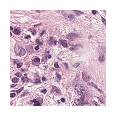
<figcaption>(e)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-6">
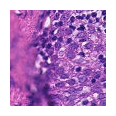
<figcaption>(f)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-7">
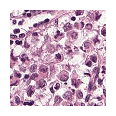
<figcaption>(g)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-8">
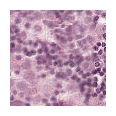
<figcaption>(h)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-9">
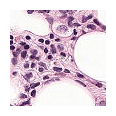
<figcaption>(i)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-10">
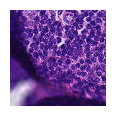
<figcaption>(j)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-11">
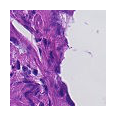
<figcaption>(k)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-12">
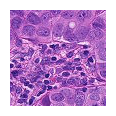
<figcaption>(l)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-13">
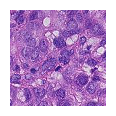
<figcaption>(m)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-14">
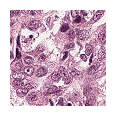
<figcaption>(n)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-15">
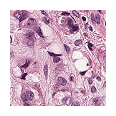
<figcaption>(o)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-16">
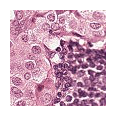
<figcaption>(p)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-17">
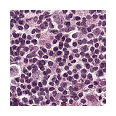
<figcaption>(q)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-18">
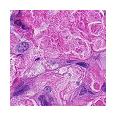
<figcaption>(r)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-19">
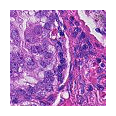
<figcaption>(s)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-20">
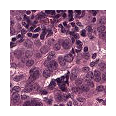
<figcaption>(t)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-21">
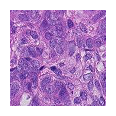
<figcaption>(u)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-22">
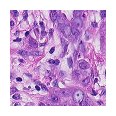
<figcaption>(v)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-23">
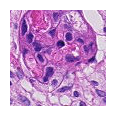
<figcaption>(w)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-24">
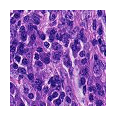
<figcaption>(x)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-25">
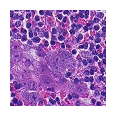
<figcaption>(y)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 3: Sample of Positive Training Images

#### 2.2.1.2 Negative Sample Images

``` python
negative_labels = df.loc[df['label'] == 0, 'id'].iloc[:25].to_list()
plot_cancer_images(negative_labels)
```

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-1">
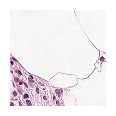
<figcaption>(a)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-2">
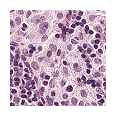
<figcaption>(b)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-3">
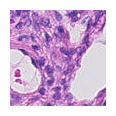
<figcaption>(c)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-4">
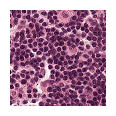
<figcaption>(d)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-5">
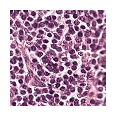
<figcaption>(e)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-6">
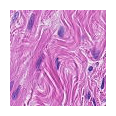
<figcaption>(f)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-7">
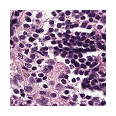
<figcaption>(g)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-8">
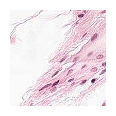
<figcaption>(h)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-9">
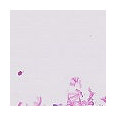
<figcaption>(i)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-10">
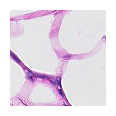
<figcaption>(j)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-11">
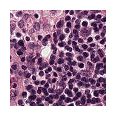
<figcaption>(k)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-12">
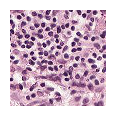
<figcaption>(l)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-13">
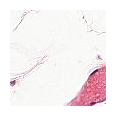
<figcaption>(m)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-14">
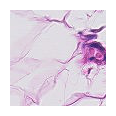
<figcaption>(n)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-15">
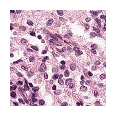
<figcaption>(o)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-16">
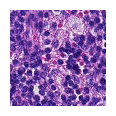
<figcaption>(p)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-17">
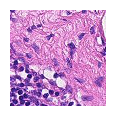
<figcaption>(q)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-18">
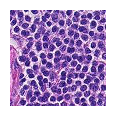
<figcaption>(r)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-19">
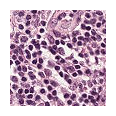
<figcaption>(s)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-20">
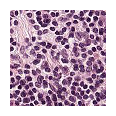
<figcaption>(t)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-21">
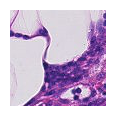
<figcaption>(u)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-22">
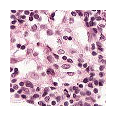
<figcaption>(v)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-23">
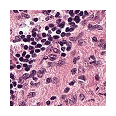
<figcaption>(w)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-24">
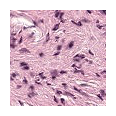
<figcaption>(x)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-25">
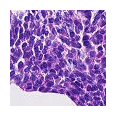
<figcaption>(y)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 4: Sample of Negative Training Images

In <a href="#fig-train-images-sample-positive"
class="quarto-xref">Figure 3</a> and
<a href="#fig-train-images-sample-negative"
class="quarto-xref">Figure 4</a> we observe that both image classes
appear to have similar color characteristics with the color pallet
leaning towards red/purple. Additionally, some of the negative training
images have large areas of white, but this could be due to chance.
Overall, both classes appear to be candidates for identification using
CNN techniques.

### 2.2.2 Zoomed Image Comparison

Of additional interest is a visual inspection of the images cropped to
the cancer detection area of 32 x 32 px. All positive and negative
samples are the same as above.

#### 2.2.2.1 Zoomed Positive Sample Images

``` python
positive_labels = df.loc[df['label'] == 1, 'id'].iloc[:25].to_list()
plot_cancer_images(positive_labels, zoom=True, scale_factor=3)
```

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-1">
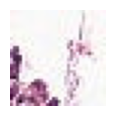
<figcaption>(a)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-2">
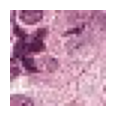
<figcaption>(b)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-3">
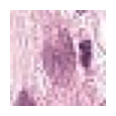
<figcaption>(c)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-4">
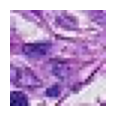
<figcaption>(d)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-5">
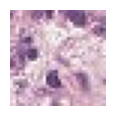
<figcaption>(e)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-6">
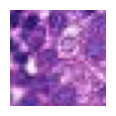
<figcaption>(f)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-7">
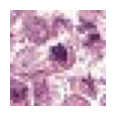
<figcaption>(g)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-8">
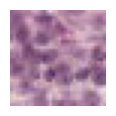
<figcaption>(h)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-9">
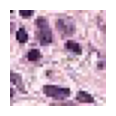
<figcaption>(i)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-10">
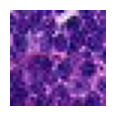
<figcaption>(j)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-11">
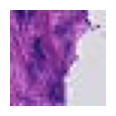
<figcaption>(k)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-12">
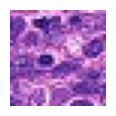
<figcaption>(l)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-13">
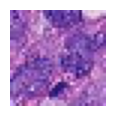
<figcaption>(m)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-14">
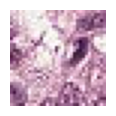
<figcaption>(n)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-15">
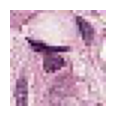
<figcaption>(o)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-16">
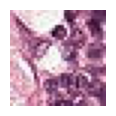
<figcaption>(p)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-17">
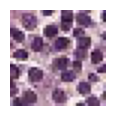
<figcaption>(q)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-18">
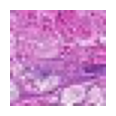
<figcaption>(r)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-19">
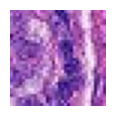
<figcaption>(s)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-20">
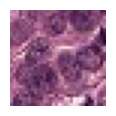
<figcaption>(t)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-21">
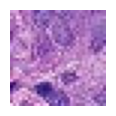
<figcaption>(u)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-22">
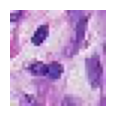
<figcaption>(v)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-23">
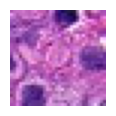
<figcaption>(w)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-24">
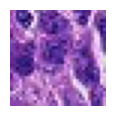
<figcaption>(x)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-positive-zoom-25">
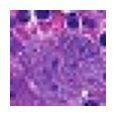
<figcaption>(y)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 5: 32 x 32px Sample of Positive Training Images

#### 2.2.2.2 Zoomed Negative Sample Images

``` python
negative_labels = df.loc[df['label'] == 0, 'id'].iloc[:25].to_list()
plot_cancer_images(negative_labels, zoom=True, scale_factor=3)
```

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-1">
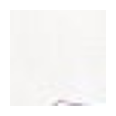
<figcaption>(a)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-2">
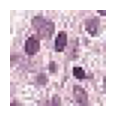
<figcaption>(b)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-3">
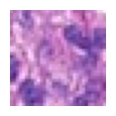
<figcaption>(c)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-4">
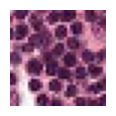
<figcaption>(d)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-5">
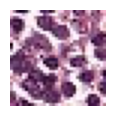
<figcaption>(e)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-6">
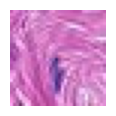
<figcaption>(f)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-7">
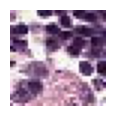
<figcaption>(g)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-8">
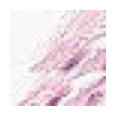
<figcaption>(h)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-9">
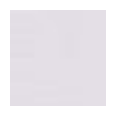
<figcaption>(i)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-10">
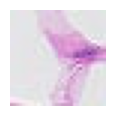
<figcaption>(j)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-11">
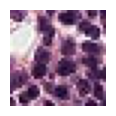
<figcaption>(k)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-12">
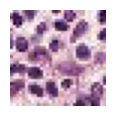
<figcaption>(l)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-13">
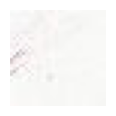
<figcaption>(m)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-14">
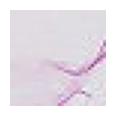
<figcaption>(n)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-15">
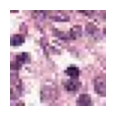
<figcaption>(o)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-16">
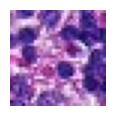
<figcaption>(p)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-17">
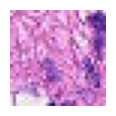
<figcaption>(q)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-18">
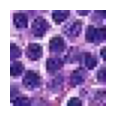
<figcaption>(r)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-19">
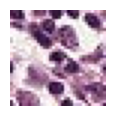
<figcaption>(s)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-20">
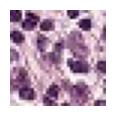
<figcaption>(t)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
<col style="width: 20%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-21">
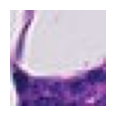
<figcaption>(u)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-22">
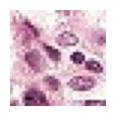
<figcaption>(v)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-23">
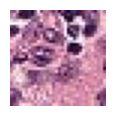
<figcaption>(w)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-24">
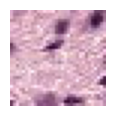
<figcaption>(x)</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="20.0%"
data-layout-align="left">
<figure id="fig-train-images-sample-negative-zoom-25">
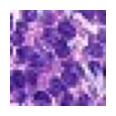
<figcaption>(y)</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 6: 32 x 32px Sample of Negative Training Images

In <a href="#fig-train-images-sample-positive-zoom"
class="quarto-xref">Figure 5</a> and
<a href="#fig-train-images-sample-negative-zoom"
class="quarto-xref">Figure 6</a> we again observe no obvious differences
between the two classes. Some of the negative samples are predominately
white, which should be easily classified by the CNN models.

# 3. Convolutional Neural Network Models

In this section, we outline the CNN architectures developed for this
project, including their implementation in
[PyTorch](https://pytorch.org) (Ansel et al. 2024). Each model—VGNet,
InceptionNet, and ResNet—is built upon the foundational papers detailing
their respective architectures, which have set benchmarks for
convolutional neural networks in computer vision tasks. We will train
and evaluate each architecture to assess its performance on the PCam
dataset.

Each model is designed to accept input images of dimensions 96×96,
48×48, or 32×32 pixels with three color channels (RGB). The output layer
is configured to predict a binary classification, producing a 0 or 1
depending on the model’s prediction. This design aligns with PCam input
data and ensures consistency across architectures while allowing for
comparative analysis of performance under varying input resolutions.

## 3.1 VGNet PyTorch Definition

VGNet as described in *Very Deep Convolutional Networks for Large-Scale
Image Recognition* (Simonyan and Zisserman 2015), is a deep CNN designed
for large-scale image classification tasks. The architecture consists of
a series of convolutional layers followed by fully connected layers. The
key feature of VGNet is its depth, with a large number of layers
contributing to its high capacity for learning from complex data.

In <a href="#lst-vgnet" class="quarto-xref">Listing 1</a>, we define the
layers in the following order:

1.  Three convolutional blocks with increasing numbers of filters.
2.  MaxPooling layers to reduce spatial dimensions.
3.  Fully connected layers to classify the output features.

The network is designed to take an input image and output a prediction
for one of the predefined classes. The code provided below is a direct
translation of the VGNet architecture to PyTorch.

    class VGNet(nn.Module):
        def __init__(self, input_size, num_classes=2):
            super(VGNet, self).__init__()
            # Define 3 convolution layers
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
            self.pool1 = nn.MaxPool2d(2, 2)

            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
            self.pool2 = nn.MaxPool2d(2, 2)

            self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
            self.pool3 = nn.MaxPool2d(2, 2)

            self.input_size = input_size
            self.feature_map_size = self._get_feature_map_size(input_size)

            self.fc1 = nn.Linear(self.feature_map_size, 1024)
            self.fc2 = nn.Linear(1024, 1024)
            # Binary Classification
            self.fc3 = nn.Linear(1024, num_classes)

        # Handle different size images
        def _get_feature_map_size(self, input_size):
            size = input_size // 2  # After pool1
            size = size // 2  # After pool2
            size = size // 2  # After pool3
            return 256 * size * size  # 256 channels in the last conv layer

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)

            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = self.pool2(x)

            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            x = self.pool3(x)

            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

Listing 1: VGNet PyTorch CNN Model

## 3.2 InceptionNet PyTorch Definition

This InceptionNet model is based on *Going Deeper With Convolutions*
(Szegedy et al. 2014). InceptionNet introduces the idea of using
multiple filter sizes in parallel within the same layer, which allows
the model to capture different types of features. The architecture
includes various branches, each performing a different convolution
operation, and these are concatenated to form the output.

In <a href="#lst-inception" class="quarto-xref">Listing 2</a> we define
the InceptionBlock, which contains these multiple branches, and then
stack two such blocks in sequence. The network also uses a large initial
convolution layer and pooling layers for spatial dimension reduction.
The final output is classified through a fully connected layer.

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels, 64, kernel_size=1)

            self.branch3x3 = nn.Sequential(
                nn.Conv2d(in_channels, 64, kernel_size=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
            )

            self.branch5x5 = nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=1),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
            )

            self.branch_pool = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels, 64, kernel_size=1),
            )

        def forward(self, x):
            branch1x1 = self.branch1x1(x)
            branch3x3 = self.branch3x3(x)
            branch5x5 = self.branch5x5(x)
            branch_pool = self.branch_pool(x)
            return torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)


    class InceptionNetLike(nn.Module):
        def __init__(self, input_size, num_classes=2):
            super(InceptionNetLike, self).__init__()
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
            self.pool1 = nn.MaxPool2d(3, 2, padding=1)

            self.inception1 = InceptionBlock(64)
            self.inception2 = InceptionBlock(320)
            self.pool2 = nn.MaxPool2d(3, 2, padding=1)

            # Dynamically compute the flattened size for the fully connected layer
            self.input_size = input_size
            self.feature_map_size = self._get_feature_map_size(input_size)
            self.fc = nn.Linear(self.feature_map_size, num_classes)


        # Handle different sized inputs
        def _get_feature_map_size(self, input_size):
            size = (input_size + 2 * 3 - 7) // 2 + 1  # After conv1
            size = (size + 2 * 1 - 3) // 2 + 1  # After pool1
            size = (size + 2 * 1 - 3) // 2 + 1  # After pool2
            return 320 * size * size  # 320 channels in the last InceptionBlock

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.pool1(x)

            x = self.inception1(x)
            x = self.inception2(x)
            x = self.pool2(x)

            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

Listing 2: InceptionNet PyTorch CNN Model

## 3.3 ResNet PyTorch Definition

ResNet introduced in *Deep Residual Learning for Image Recognition* (He
et al. 2015), is known for its innovative use of residual connections,
which help mitigate the problem of vanishing gradients in deep networks.
These connections allow the network to learn residual functions instead
of direct mappings, significantly improving the training of very deep
networks.

The following PyTorch implementation follows the ResNet-like
architecture with three layers, each containing multiple residual
blocks. The model utilizes batch normalization and convolutional layers
to progressively extract features before classifying them with a fully
connected layer.

    class ResNetLike(nn.Module):
        def __init__(self, input_size, num_classes=2):
            super(ResNetLike, self).__init__()
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(64)

            self.layer1 = self._make_layer(64, 64, stride=1)
            self.layer2 = self._make_layer(64, 128, stride=2)
            self.layer3 = self._make_layer(128, 256, stride=2)

            # Hard code feature map output size
            if input_size == 32:
                # 16384
                self.feature_map_size = 32 * 512
            elif input_size == 48:
                # 36864
                self.feature_map_size = 48 * 768
            else:
                # 1478956
                self.feature_map_size = 96 * 1536

            self.fc = nn.Linear(self.feature_map_size, num_classes)

        def _make_layer(self, in_channels, out_channels, stride):
            return nn.Sequential(
                ResidualBlock(in_channels, out_channels, stride),
                ResidualBlock(out_channels, out_channels, 1),
            )

        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

Listing 3: ResNet PyTorch CNN Model

# 4. Training

Training convolutional neural networks (CNNs) involves several key
steps, from preparing the data for model consumption to optimizing the
model parameters using backpropagation. In this section, we define and
detail the critical components of the required to train each model.

## 4.1 Data Loader

Using PyTorch’s `DataLoader`, the input is split into training and
validation subsets with batching and shuffling enabled. The
`CancerDataset` class handles loading and preprocessing image data.
Transformations are specified as global variables and passed as input
into the `CancerDataset` class.

## 4.2 Training Loop

The training loop uses a cross-entropy loss function and the Adam
optimizer to adjust the model’s parameters. During each epoch, batches
of data are passed through the model, and the loss is computed and
minimized using backpropagation. The loop is designed to iteratively
improve the model’s ability to predict class labels accurately.

## 4.3 Hyperparameter Determination

The training process begins with three predefined model architectures,
serving as the foundation for hyperparameter exploration. The key focus
is to identify static (unchanging) and dynamic (tunable) hyperparameters
to optimize model performance. By concentrating on high-impact
hyperparameters, the project narrows its scope to a manageable set of
experiments, balancing the need for thorough exploration with practical
constraints. This methodical approach prevents an unbounded exploration
of the hyperparameter space while still ensuring robust optimization of
the selected models.

### 4.3.1 Batch Size

`batch_size` is an integer passed to
[`torch.utils.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader),
specifies the number of samples loaded per batch. During initial
experiments, batch size showed a clear correlation with both model
execution time and memory usage, making it a critical hyperparameter to
tune.

To determine the optimal batch size, multiple experiments were conducted
using a single model architecture while varying the batch size. The
results revealed a tradeoff between execution time and batch size.

``` python
batch_model_path = Path("../model_metrics_output/").resolve()
batch_model_files = [
    Path(batch_model_path, "v2.epochs_1.batch_size_8.parquet"),
    Path(batch_model_path, "v2.epochs_1.batch_size_16.parquet"),
    Path(batch_model_path, "v2.epochs_1.batch_size_32.parquet"),
    Path(batch_model_path, "v2.epochs_5.batch_size_64.parquet"),
    Path(batch_model_path, "v2.epochs_1.batch_size_128.parquet"),
    Path(batch_model_path, "v2.epochs_1.batch_size_256.parquet"),
    Path(batch_model_path, "v2.epochs_1.batch_size_512.parquet"),
]

batch_df = [pd.read_parquet(f) for f in batch_model_files]

batch_df[0].head()

mean_times = []
batch_sizes = []

for df, file_path in zip(batch_df, batch_model_files):
    name = file_path.name
    parts = name.split(".")
    batch_size = int(parts[2].split("_")[-1])
    mean_execution_time = df["execution_time"].mean()

    batch_sizes.append(batch_size)
    mean_times.append(mean_execution_time)

batch_time_df = pd.DataFrame({"Mean Execution Time [s]": mean_times}, index=batch_sizes)
batch_time_df.index.name = "Batch Size"

batch_time_df.plot(
    kind="bar",
    figsize=(8, 2.5),
    # linewidth=0.5,
    # marker=".",
    # markersize=1.5,
    ylabel="Execution Time [s]",
    legend=False,
    rot=0,
)
plt.ylim(0, 400)
```

<figure id="fig-batch-size-exc-time">
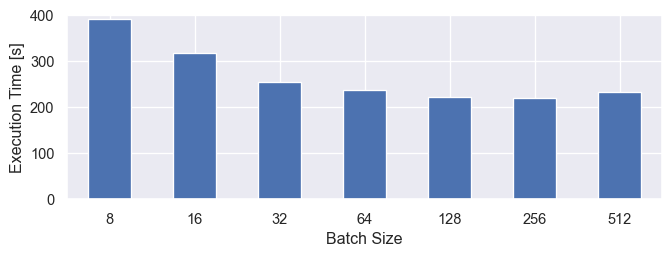
<figcaption>Figure 7: Execution Time vs. Batch Size</figcaption>
</figure>

``` python
batch_time_df = batch_time_df.reset_index()
batch_time_df = batch_time_df.round(2)
batch_time_df
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | Batch Size | Mean Execution Time \[s\] |
|-----|------------|---------------------------|
| 0   | 8          | 390.50                    |
| 1   | 16         | 316.26                    |
| 2   | 32         | 255.17                    |
| 3   | 64         | 236.77                    |
| 4   | 128        | 221.08                    |
| 5   | 256        | 220.11                    |
| 6   | 512        | 232.28                    |

</div>

Table 7: Mean Execution Time

From the batch size exploration detailed in
<a href="#fig-batch-size-exc-time" class="quarto-xref">Figure 7</a> and
<a href="#tbl-batch-size-vs-exec" class="quarto-xref">Table 7</a>, it
was observed that a batch size of 256 provided an optimal balance
between execution time and resource usage for this model architecture.
This batch size will be set at `256` for all training runs, enabling the
most efficient use of time.

### 4.3.2 Image Size

During the early stages of testing, the effect of image size on model
performance was uncovered through unexpected observations. Initial
experiments omitted cropping during testing, leading to higher test
accuracy. However, when a cropping strategy was later applied to
validation data, validation accuracy decreased by approximately 15%.
This discrepancy highlighted the importance of exploring the
relationship between image size and model performance.

In experimenting with various cropping strategies, we observed that
altering cropping dimensions significantly influenced model accuracy.
Specifically, cropping sizes of 32 pixels, 48 pixels, and no cropping
were identified as key hyperparameters for tuning. These variations had
a substantial impact on the model’s generalization capabilities,
emphasizing the critical role of image preprocessing in the model
pipeline.

Image size does have an effect on the model execution time, which is
detailed in
<a href="#sec-model-exec-time" class="quarto-xref">Section 4.8</a>.

### 4.3.3 Other Potential Hyperparameters

Several other potential dynamic hyperparameters were considered during
the exploration phase, including:

-   Stride: Adjusting the step size during convolution operations.
-   Padding: Modifying the boundary handling during convolutions.
-   Model Layers and Complexity: Exploring deeper or more complex
    architectures.
-   Randomizing Input Images: Introducing variability in training
    samples.
-   Normalizing Input Images: Standardizing pixel values for faster
    convergence.

While these parameters are likely influence model performance, they were
ultimately kept static. This decision was motivated by the need to
balance computational feasibility with meaningful experimentation, given
the constraints of this project.

## 4.4 Training Specification

This section specificions for the trained models. A total of nine models
were trained, each evaluated over 100 epochs with a batch size of 256.
The Adam optimizer was employed with a learning rate of 0.001, and the
loss function was defined as cross-entropy, reflecting the binary
classification nature of the task. Notably, no image normalization
techniques were applied during preprocessing, while padding and stride
were set to 1 to maintain the spatial dimensions of the input.

The models were designed using three distinct architecture types: VGNet,
InceptionNet, and ResNet, to assess the impact of architectural
variation on performance. Additionally, three cropping types (none, 48px
center, and 32px center) were explored to understand how spatial input
modifications influence learning. Tables
<a href="#tbl-common-model-params" class="quarto-xref">Table 8</a> and
<a href="#tbl-changed-model-params" class="quarto-xref">Table 9</a>
summarize the hyperparameters that remained consistent across
experiments and those that varied between models, respectively.

| Description         |         Value |
|:--------------------|--------------:|
| Models Trained      |             9 |
| Number of Epochs    |           100 |
| Batch Size          |           256 |
| Optimizer           |          Adam |
| Learning Rate       |         0.001 |
| Loss Function       | Cross Entropy |
| Image Normalization |          None |
| Padding             |             1 |
| Stride              |             1 |

Table 8: Common Model Hyperparameters

| Description    |                              Value |
|:---------------|-----------------------------------:|
| Model Types    |    3 (VGNet, InceptionNet, ResNet) |
| Cropping Types | 3 (None, 48px Center, 32px Center) |

Table 9: Changed Model Hyperparameters

## 4.5 Training Flowchart

Visualized in
<a href="#fig-train-detailed" class="quarto-xref">Figure 8</a>, the
training process begins with defining the CNN architecture and
initializing key hyperparameters, such as model type and input image
size. Training is conducted using labeled image patches, with the model
learning to classify cancerous and non-cancerous regions. Testing
evaluates the model’s accuracy and robustness, enabling the
identification of strengths and weaknesses. Results are iteratively
refined by tuning hyperparameters, retraining models, and optimizing
their architectures.

<figure id="fig-train-detailed">
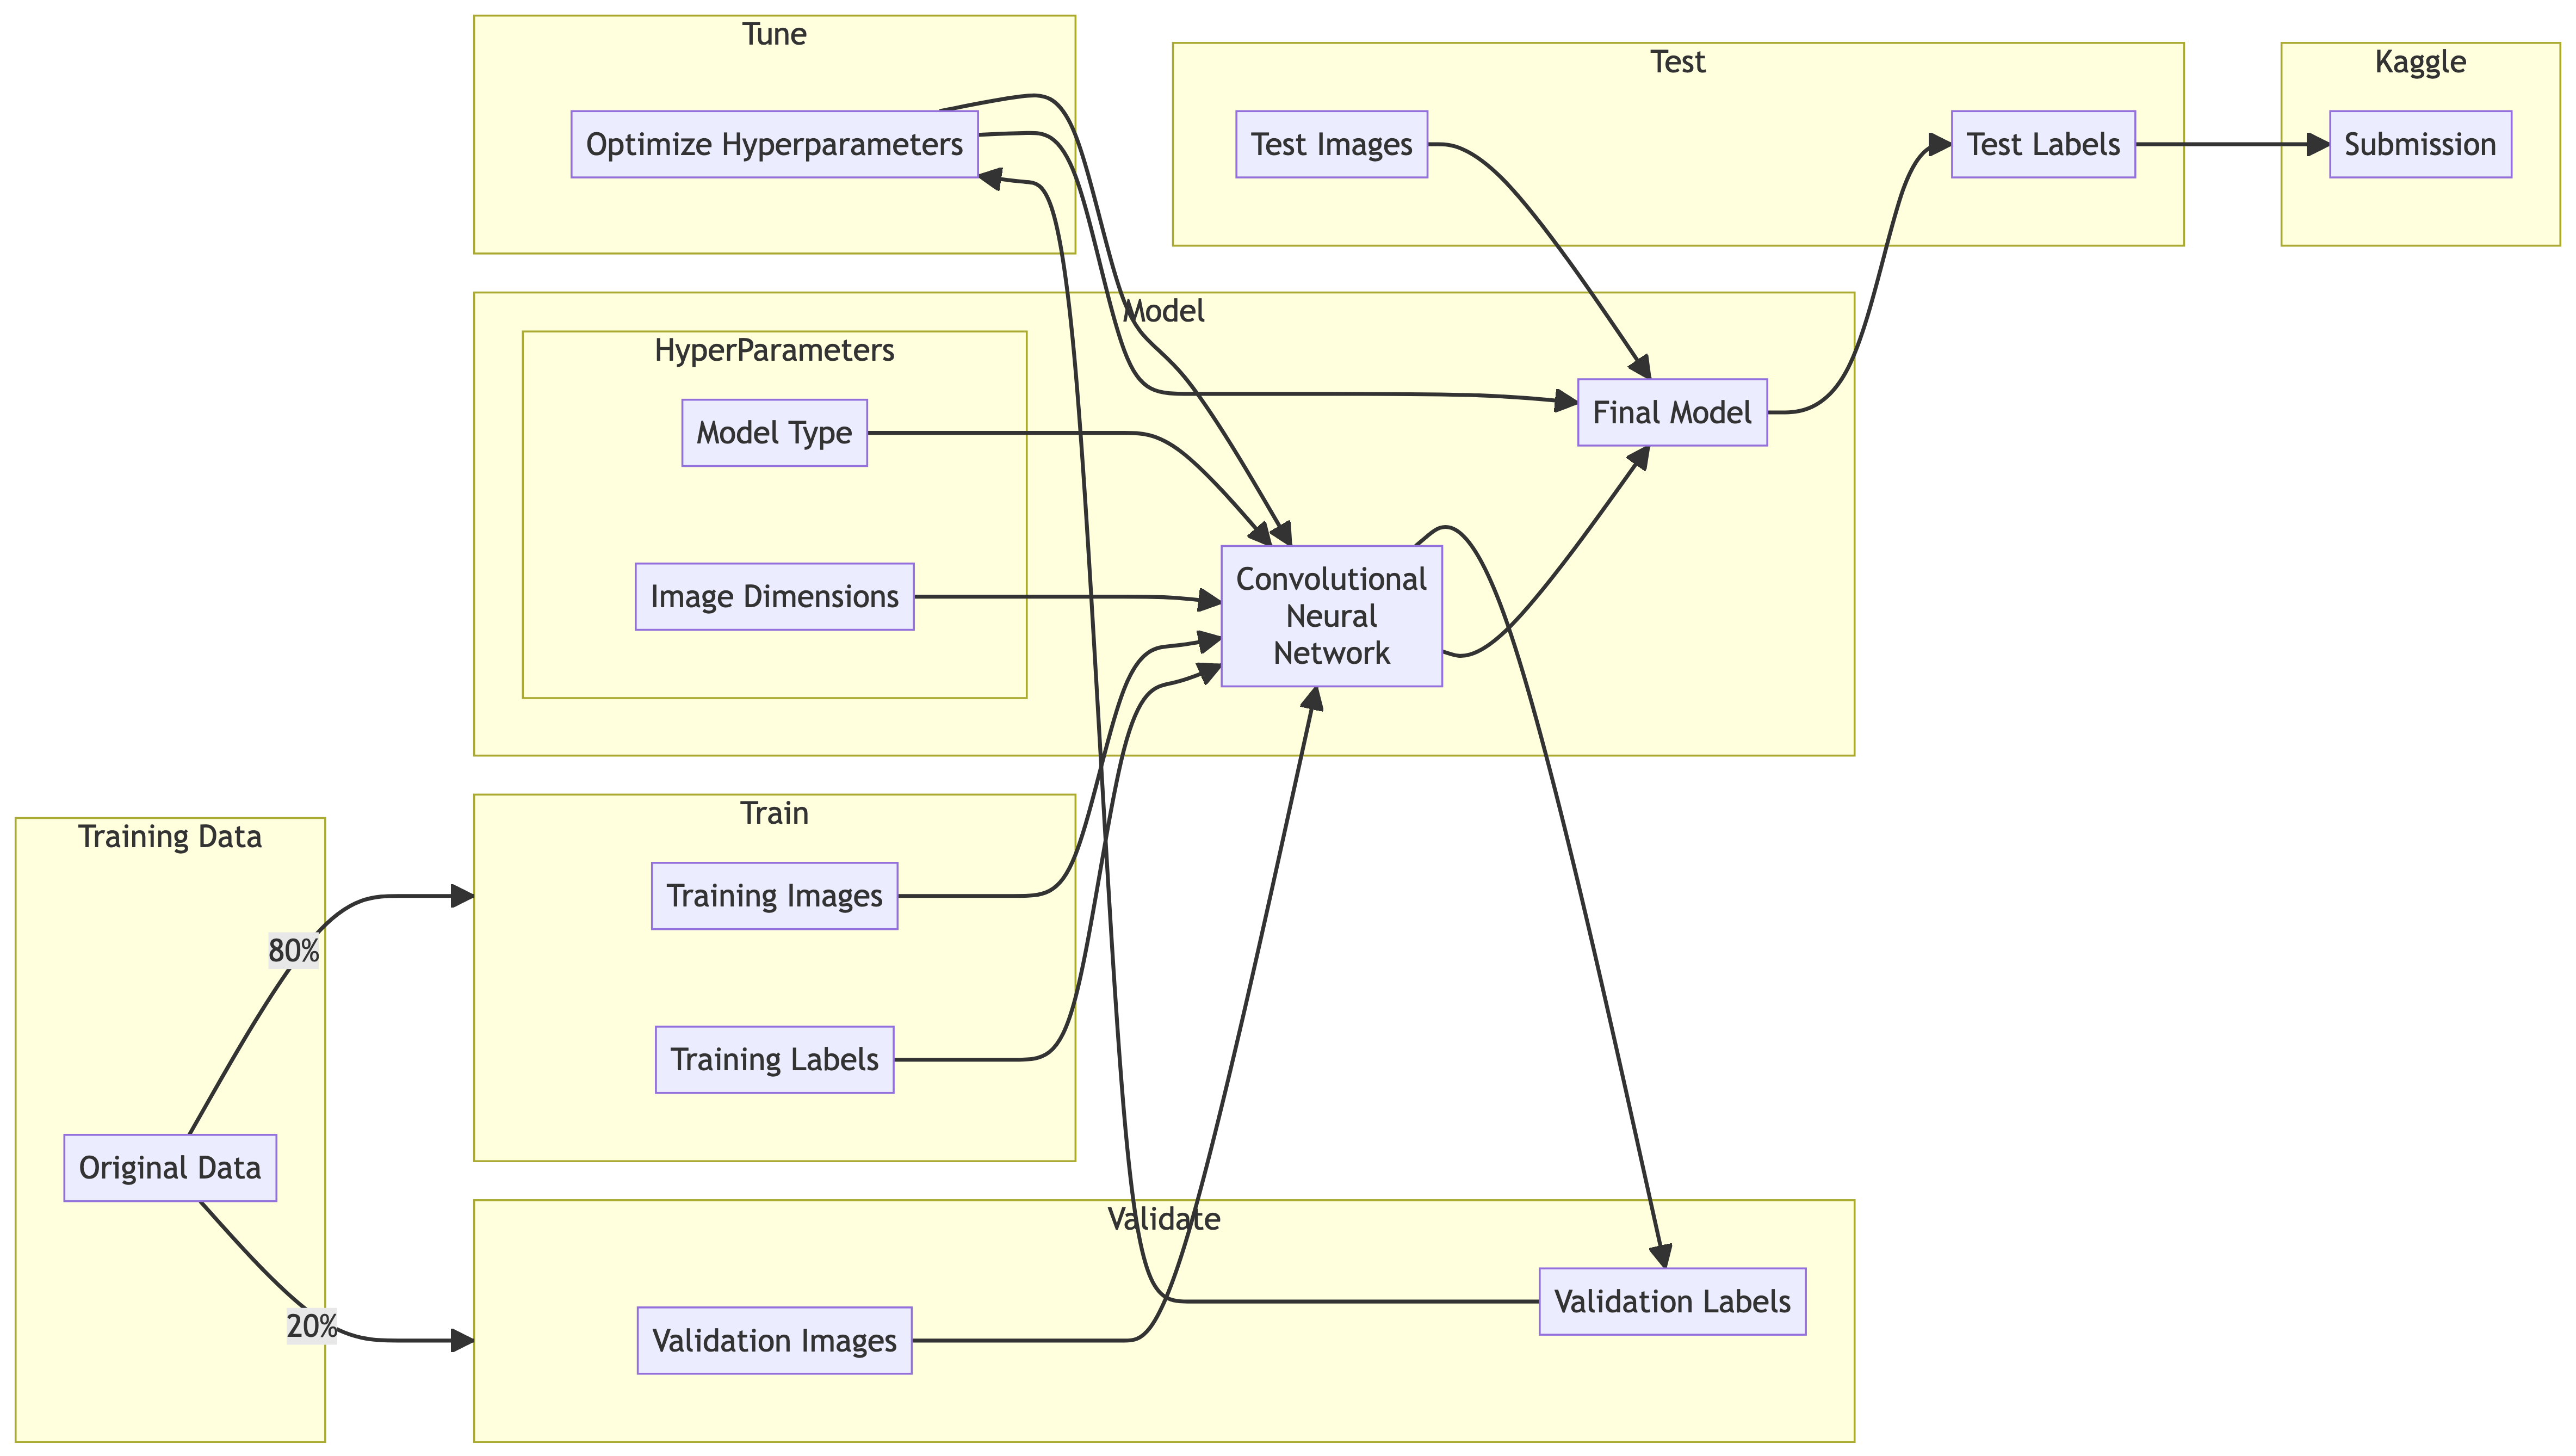
<figcaption>Figure 8: Detailed Project Flowchart</figcaption>
</figure>

## 4.6 Training Hardware

This project utilizes an M2 MacBook Pro Max with 32GB of RAM, leveraging
PyTorch’s Metal Performance Shaders backend for GPU acceleration. The
Metal backend enables efficient training on Apple Silicon devices,
harnessing the GPU to accelerate deep learning workloads. This setup was
chosen as a stable alternative to the Kaggle platform and has adequate
performance.

## 4.7 Training Procedure

Models were trained sequentially in the order specified in
<a href="#tbl-train-order" class="quarto-xref">Table 10</a>. Model
specifications are passed via command line arguments and each model run
starts the script in a clean state. In total 9 model runs were performed
with different combinations of model and crop hyperparameters. All other
parameters specified in
<a href="#tbl-common-model-params" class="quarto-xref">Table 8</a> were
held constant for all training runs.

| Training Run \# | Model Hyperparameter | Crop Specification Hyperparameter |
|-----------------|----------------------|-----------------------------------|
| 1               | VGNet                | 32 x 32                           |
| 2               | InceptionNet         | 32 x 32                           |
| 3               | ResNet               | 32 x 32                           |
| 4               | VGNet                | 48 x 48                           |
| 5               | InceptionNet         | 48 x 48                           |
| 6               | ResNet               | 48 x 48                           |
| 7               | VGNet                | Full Resolution                   |
| 8               | InceptionNet         | Full Resolution                   |
| 9               | ResNet               | Full Resolution                   |

Table 10: Training Order

During each each epoch of each training run the following metrics were
collected and saved.

| Name           | Unit    |
|----------------|---------|
| Epoch          | Count   |
| Execution Time | Seconds |
| Training Loss  | Average |
| Model Specs    | String  |

Table 11: List of Collected Model Metrics

These metrics will be used to determine the performance of each model

## 4.8 Model Execution Times

``` python
import seaborn as sns
sns.set_theme()

results_path = Path("../model_metrics_output/").resolve()
metrics = [
    "v3.model_type_VGNet.transform_32PX_CROP.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_InceptionNet.transform_32PX_CROP.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_ResNet.transform_32PX_CROP.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_VGNet.transform_48PX_CROP.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_InceptionNet.transform_48PX_CROP.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_ResNet.transform_48PX_CROP.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_VGNet.transform_NONE.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_InceptionNet.transform_NONE.padding_1.stride_1.epochs_spec_100.parquet",
    "v3.model_type_ResNet.transform_NONE.padding_1.stride_1.epochs_spec_100.parquet",
]


metrics_df = [pd.read_parquet(Path(results_path, p)) for p in metrics]

metrics_combined = pd.concat(metrics_df, axis="index")


# Parse model type from the model column
metrics_combined['model_type'] = metrics_combined['model'].str.extract(r'model_type_([A-Za-z0-9]+)')

# Group by model_type and aggregate the required metrics
metrics_grouped = metrics_combined.groupby('model').agg(
    max_epoch=('epoch', 'max'),
    mean_learning_rate=('learning_rate', 'mean'),
    mean_execution_time=('execution_time', 'mean'),
    max_execution_time=('execution_time', 'max'),
    min_execution_time=('execution_time', 'min'),
    total_execution_time=('execution_time', 'sum'),
    mean_training_loss=('training_loss', 'mean'),
    max_training_loss=('training_loss', 'max'),
    min_training_loss=('training_loss', 'min')
).reset_index()

# Extract model_type and transform_type from the 'model' column
metrics_grouped['model_type'] = metrics_grouped['model'].str.extract(r'model_type_([A-Za-z0-9]+)')
metrics_grouped['transform_type'] = metrics_grouped['model'].str.extract(r'transform_([A-Za-z0-9_]+)')

# metrics_grouped['transform_type' == "NONE"] = "Full Resolution"
# metrics_grouped['transform_type' == "48PX_CROP"] = "Center Crop - 48PX"
# metrics_grouped['transform_type' == "32PX_CROP"] = "Center Crop - 32PX"
# metrics_grouped['training_time_seconds']

metrics_grouped.loc[metrics_grouped['transform_type'] == "NONE", 'transform_type'] = "Full Resolution"
metrics_grouped.loc[metrics_grouped['transform_type'] == "48PX_CROP", 'transform_type'] = "Center Crop - 48PX"
metrics_grouped.loc[metrics_grouped['transform_type'] == "32PX_CROP", 'transform_type'] = "Center Crop - 32PX"


metrics_grouped['total_execution_time_hours'] = metrics_grouped['total_execution_time'] / 60 / 60

metrics_grouped = metrics_grouped.sort_values(['total_execution_time'], ascending=False)
# metrics_grouped[["model_type", "transform_type", "total_execution_time_hours", "mean_execution_time", "max_execution_time",
# "min_execution_time"]]

# Calculate the error bars
metrics_grouped['error_min'] = metrics_grouped['mean_execution_time'] - metrics_grouped['min_execution_time']
metrics_grouped['error_max'] = metrics_grouped['max_execution_time'] - metrics_grouped['mean_execution_time']

# Combine errors for yerr
metrics_grouped['yerr'] = list(zip(metrics_grouped['error_min'], metrics_grouped['error_max']))

# Create the barplot
plt.figure(figsize=(7.5, 3.5))
barplot = sns.barplot(
    data=metrics_grouped,
    x="model_type",
    y="mean_execution_time",
    hue="transform_type",
    errorbar=None
)

# Add error bars
for idx, bar in enumerate(barplot.patches[:-3]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    error = metrics_grouped['yerr'][idx]
    plt.errorbar(x, y, yerr=[[error[0]], [error[1]]], fmt='none', c='black', capsize=5)

plt.ylabel("Execution Time Per Epoch [s]")
plt.xlabel(None)
plt.legend(title="Transform Type")
plt.tight_layout()
plt.show()
```

<figure id="fig-exec-times-per-epoch">
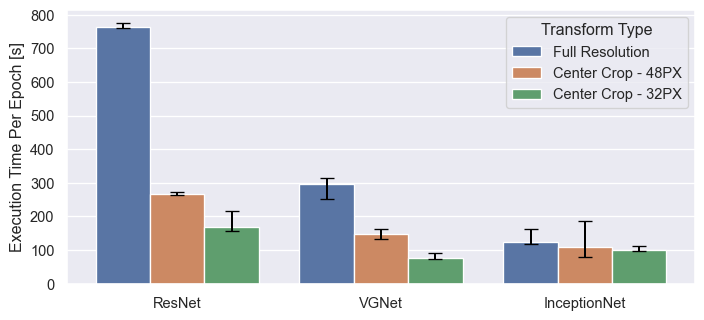
<figcaption>Figure 9: Model Execution Time [seconds] per Training
Epoch</figcaption>
</figure>

``` python
plt.figure(figsize=(7.5, 3.5))
sns.barplot(metrics_grouped, x = "model_type", y="total_execution_time_hours", hue="transform_type")

plt.ylabel("Total Execution Time Per Epoch [Hours]")
plt.xlabel(None)
plt.legend(title="Transform Type")
plt.tight_layout()
plt.show()
```

<figure id="fig-total-exec-times">
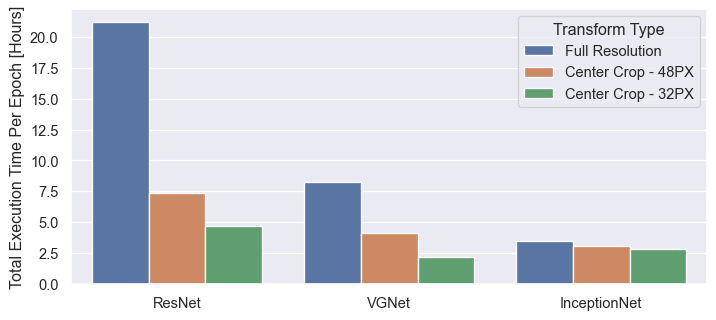
<figcaption>Figure 10: Model Total Execution Time [Hours]</figcaption>
</figure>

``` python
print(metrics_grouped.info())
metrics_grouped.head()
```

    <class 'pandas.core.frame.DataFrame'>
    Index: 9 entries, 5 to 6
    Data columns (total 16 columns):
     #   Column                      Non-Null Count  Dtype  
    ---  ------                      --------------  -----  
     0   model                       9 non-null      object 
     1   max_epoch                   9 non-null      int64  
     2   mean_learning_rate          9 non-null      float64
     3   mean_execution_time         9 non-null      float64
     4   max_execution_time          9 non-null      float64
     5   min_execution_time          9 non-null      float64
     6   total_execution_time        9 non-null      float64
     7   mean_training_loss          9 non-null      float64
     8   max_training_loss           9 non-null      float64
     9   min_training_loss           9 non-null      float64
     10  model_type                  9 non-null      object 
     11  transform_type              9 non-null      object 
     12  total_execution_time_hours  9 non-null      float64
     13  error_min                   9 non-null      float64
     14  error_max                   9 non-null      float64
     15  yerr                        9 non-null      object 
    dtypes: float64(11), int64(1), object(4)
    memory usage: 1.5+ KB
    None

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|  | model | max_epoch | mean_learning_rate | mean_execution_time | max_execution_time | min_execution_time | total_execution_time | mean_training_loss | max_training_loss | min_training_loss | model_type | transform_type | total_execution_time_hours | error_min | error_max | yerr |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| 5 | v3.model_type_ResNet.transform_NONE.padding_1.... | 100 | 0.001 | 764.092020 | 842.218212 | 734.275649 | 76409.202002 | 0.043401 | 1.139886 | 0.003890 | ResNet | Full Resolution | 21.224778 | 29.816371 | 78.126192 | (29.81637118577953, 78.12619210958485) |
| 8 | v3.model_type_VGNet.transform_NONE.padding_1.s... | 100 | 0.001 | 297.820536 | 310.311009 | 294.249442 | 29782.053566 | 0.030344 | 0.442181 | 0.003682 | VGNet | Full Resolution | 8.272793 | 3.571094 | 12.490473 | (3.571093802452083, 12.490473265647893) |
| 4 | v3.model_type_ResNet.transform_48PX_CROP.paddi... | 100 | 0.001 | 266.090062 | 282.700538 | 251.574150 | 26609.006231 | 0.055947 | 0.578099 | 0.006972 | ResNet | Center Crop - 48PX | 7.391391 | 14.515912 | 16.610476 | (14.515912227630622, 16.610475845336907) |
| 3 | v3.model_type_ResNet.transform_32PX_CROP.paddi... | 100 | 0.001 | 168.808576 | 176.997332 | 165.752459 | 16880.857594 | 0.073267 | 0.579238 | 0.012466 | ResNet | Center Crop - 32PX | 4.689127 | 3.056117 | 8.188756 | (3.056116886138909, 8.18875616073609) |
| 7 | v3.model_type_VGNet.transform_48PX_CROP.paddin... | 100 | 0.001 | 146.973338 | 159.053998 | 143.082328 | 14697.333795 | 0.061036 | 0.480737 | 0.009605 | VGNet | Center Crop - 48PX | 4.082593 | 3.891010 | 12.080660 | (3.8910101079940773, 12.080660281181338) |

</div>

In [19]:
# metrics_grouped.info()
metrics_grouped = metrics_grouped.sort_values(["total_execution_time_hours"], ascending=False)
metrics_grouped = metrics_grouped.reset_index()
metrics_grouped = metrics_grouped.rename({
    "model_type": "Model Type",
    "transform_type": "Transform Type",
    "total_execution_time_hours": "Execution Time [Hours]"
}, axis="columns")

min_execution_time = metrics_grouped["Execution Time [Hours]"].min()
metrics_grouped["Time Factor"] = metrics_grouped["Execution Time [Hours]"] / min_execution_time


metrics_grouped[['Model Type', 'Transform Type', 'Execution Time [Hours]', "Time Factor"]]

## 4.9 Confusion Matricies

After each model run a confusion matrix generated by passing the
validation data into the model and performing calculations on the
predicted output. The following confusion matrix and classification
report provide a comprehensive evaluation of the VGNet model’s
performance when trained on 32×32 px images.

In [20]:
confusion_matrix = pd.read_parquet("./week_3_sample_confusion_matrix.parquet")
confusion_matrix

In <a href="#tbl-confusion-matrix" class="quarto-xref">Table 12</a> we
observe:

-   True Positives (17420): The model correctly identified 17,420 true
    values.
-   True Negatives (25916): The model correctly predicted 25,916 false
    values.
-   False Positives (179): The model incorrectly predicted 179 instances
    as true when the labeled value was false.
-   False Negatives (490): The model incorrectly predicted 490 instances
    as false when the labeled value was true.

Overall this model correctly predicted
`{python} round((1 - ((490 + 179) / confusion_matrix.sum().sum())) * 100, 2)`%
of the validation data, demonstrating strong performance with a low
error rate relative to the dataset size. However, without further
testing, it is there is a high level of uncertaintity as to whether the
model generalizes well beyond the training and validation data.

## 4.10 Classification Report

In [21]:
classification_report = pd.read_parquet("./week_3_sample_classification_report.parquet")

classification_report = classification_report.rename(
    {
        "precision": "Precision",
        "recall": "Recall",
        "f1-score": "F1 Score",
    },
    axis="columns",
)

classification_report = classification_report.rename(
    {
        "Class 0": "True",
        "Class 1": "False",
        "weighted avg": "Average",
    },
    axis="index",
)

classification_report.loc[["True", "False", "Average"]][["Precision", "Recall", "F1 Score"]]

The classification report in
<a href="#tbl-class-reprt" class="quarto-xref">Table 13</a> highlights
the VGNet model’s performance across several key metrics. The model
trained on 32×32 px images achieves high accuracy, precision, recall,
and F1-scores for both classes. It shows a slight bias toward detecting
Class 0 (false), because of the slightly higher recall for this class
compared to Class 1. Despite this, the overall performance is excellent.
The low numbers of false positives and false negatives suggest that the
model is well-fitted to the training data. However, additional testing
on unseen data is necessary to confirm the model’s robustness and ensure
it is not overfitting.

## 4.11 Training Loss Results

Training loss is output during each batch using the Cross Entropy loss
function and averaged over each epoch. The loss function provides a
metric of improvement by the model and a decreasing loss function means
that the model is learning the patterns of the training dataset. The
loss function is also used to monitor overfitting and the learning rate.
An indicator of overfitting is a loss function that is lower validation
scores. An indicator of a too high learning rate is oscillating, or
increasing in the loss rate after an initial local minimum. In
<a href="#fig-training-loss-comparison-all-in-separate-by-model"
class="quarto-xref">Figure 11</a> and
<a href="#fig-training-loss-comparison-all-in-one"
class="quarto-xref">Figure 12</a>, the training loss is visualized over
epoch.

### 4.11.1 Training Loss by Model

``` python
for model in ["VGNet", "InceptionNet", "ResNet"]:
    fig, axs = plt.subplots(1, 1, figsize=(8, 2))
    for df in metrics_df:
        df = df.set_index(['epoch'])
        raw_model = df['model'].unique()[0]
        parts = raw_model.split(".")
        this_model = parts[1].split("_")[-1]
        if this_model == model:
            if "32" in parts[2]:
                this_model += " 32 px Crop"
            if "48" in parts[2]:
                this_model += " 48 px Crop"
            if "NONE" in parts[2]:
                this_model += " Original"

            df['training_loss'].plot(ax=axs, label=this_model)


    plt.ylabel("Training Loss")
    plt.xlabel("Epochs")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-training-loss-comparison-all-in-separate-by-model-1">
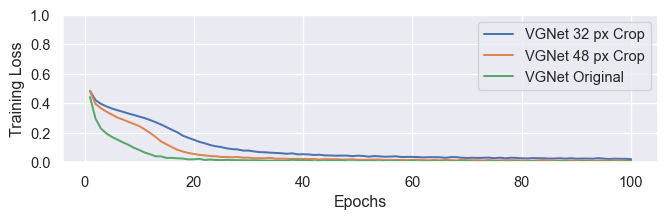
<figcaption>(a) VGNet Training Loss Comparison</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-training-loss-comparison-all-in-separate-by-model-2">
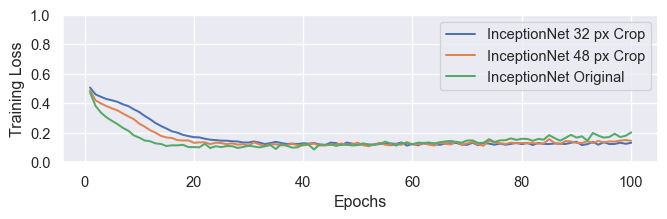
<figcaption>(b) InceptionNet Training Loss Comparison</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-training-loss-comparison-all-in-separate-by-model-3">
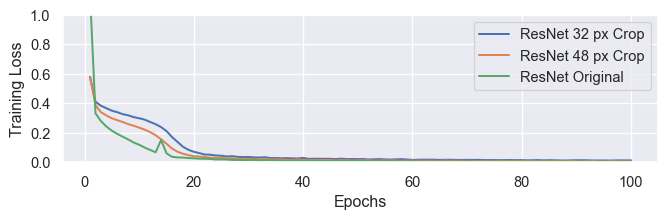
<figcaption>(c) ResNet Training Loss Comparison</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 11: Training Loss Comparison - By Model

### 4.11.2 Combined Training Loss

``` python
fig, axs = plt.subplots(1, 1, figsize=(8, 3.5))

for df in metrics_df:
    df = df.set_index(['epoch'])
    raw_model = df['model'].unique()[0]
    parts = raw_model.split(".")
    model = parts[1].split("_")[-1]
    if "32" in parts[2]:
        model += " 32 px Crop"
    if "48" in parts[2]:
        model += " 48 px Crop"
    if "NONE" in parts[2]:
        model += " Original"

    df['training_loss'].plot(ax=axs, label=model)

plt.title("Training Loss Comparison")
plt.ylabel("Training Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()
```

<figure id="fig-training-loss-comparison-all-in-one">
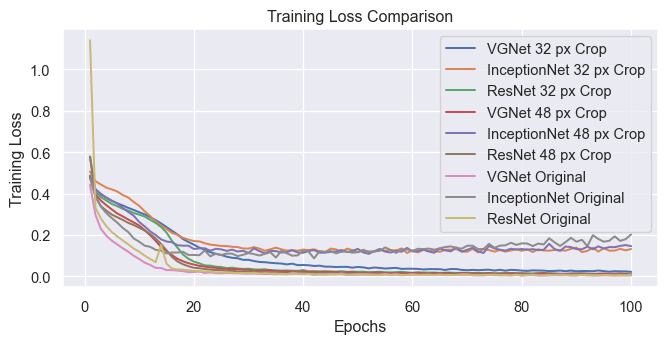
<figcaption>Figure 12: All Models - Training Loss
Comparison</figcaption>
</figure>

The training loss results in
<a href="#fig-training-loss-comparison-all-in-separate-by-model"
class="quarto-xref">Figure 11</a> and
<a href="#fig-training-loss-comparison-all-in-one"
class="quarto-xref">Figure 12</a> show that all models successfully
learned patterns from the test images. Both the VGNet and ResNet models
exhibit a significant reduction in training loss, approaching near-zero
levels after approximately 30 epochs. Notably, models trained on
full-size images achieve lower training losses more quickly compared to
those trained on cropped images. The InceptionNet model demonstrates
comparatively limited learning capacity, stabilizing at a higher
training loss of approximately 0.15 across all configurations.

The VGNet and ResNet models have no clear signs of overfitting,
maintaining stability throughout the training process. In contrast, the
InceptionNet model shows some indications of overfitting, particularly
as the training loss stabilizes without further improvement. Based on
these observations, the VGNet and ResNet models are likely to deliver
higher accuracy in their final configurations compared to the
InceptionNet model.

# 5. Results

## 5.1 Submission Procedure

The trained models were evaluated locally using the test image dataset,
and the predictions were saved to a .csv file. This file was
subsequently uploaded to Kaggle as a dataset, enabling the results to be
shared and analyzed within the competition framework. The uploaded
dataset was then read into a dataframe and used to generate the final
submission.csv file, ensuring compatibility with Kaggle’s submission
requirements.

## 5.2 Kaggle Scores

After submitting, this Kaggle competition produces a public and a
private score based on the scoring metric. The following sections detail
the results for all models.

In [24]:
kaggle_results = [
    {
        "model": "VGNet",
        "pixels": 32,
        "kaggle_version": 12,
        "kaggle_private_score": 0.7462,
        "kaggle_public_score": 0.7670,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "VGNet")
            & (metrics_grouped["Transform Type"] == "Center Crop - 32PX")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "InceptionNet",
        "pixels": 32,
        "kaggle_version": 13,
        "kaggle_private_score": 0.7037,
        "kaggle_public_score": 0.7299,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "InceptionNet")
            & (metrics_grouped["Transform Type"] == "Center Crop - 32PX")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "ResNet",
        "pixels": 32,
        "kaggle_version": 14,
        "kaggle_private_score": 0.7464,
        "kaggle_public_score": 0.7796,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "ResNet")
            & (metrics_grouped["Transform Type"] == "Center Crop - 32PX")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "VGNet",
        "pixels": 48,
        "kaggle_version": 15,
        "kaggle_private_score": 0.7734,
        "kaggle_public_score": 0.8124,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "VGNet")
            & (metrics_grouped["Transform Type"] == "Center Crop - 48PX")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "InceptionNet",
        "pixels": 48,
        "kaggle_version": 16,
        "kaggle_private_score": 0.7205,
        "kaggle_public_score": 0.7432,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "InceptionNet")
            & (metrics_grouped["Transform Type"] == "Center Crop - 48PX")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "ResNet",
        "pixels": 48,
        "kaggle_version": 17,
        "kaggle_private_score": 0.7523,
        "kaggle_public_score": 0.7551,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "ResNet")
            & (metrics_grouped["Transform Type"] == "Center Crop - 48PX")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "VGNet",
        "pixels": 96,
        "kaggle_version": 18,
        "kaggle_private_score": 0.7983,
        "kaggle_public_score": 0.8497,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "VGNet")
            & (metrics_grouped["Transform Type"] == "Full Resolution")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "InceptionNet",
        "pixels": 96,
        "kaggle_version": 19,
        "kaggle_private_score": 0.7688,
        "kaggle_public_score": 0.8163,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "InceptionNet")
            & (metrics_grouped["Transform Type"] == "Full Resolution")
        ]["Execution Time [Hours]"].values[0],
    },
    {
        "model": "ResNet",
        "pixels": 96,
        "kaggle_version": 20,
        "kaggle_private_score": 0.8198,
        "kaggle_public_score": 0.8682,
        "training_time": metrics_grouped[
            (metrics_grouped["Model Type"] == "ResNet")
            & (metrics_grouped["Transform Type"] == "Full Resolution")
        ]["Execution Time [Hours]"].values[0],
    },
]


kaggle_df = pd.DataFrame(kaggle_results)

# kaggle_df['Accuracy Per Training Hour'] = kaggle_df['training_time'] / kaggle_df["kaggle_public_score"]
kaggle_df['Accuracy Per Training Hour'] = kaggle_df['kaggle_public_score'] / kaggle_df["training_time"]

# kaggle_df['kaggle_private_score'] *= 100.0
# kaggle_df['kaggle_public_score'] *= 100.0

kaggle_df = kaggle_df.rename(
    {
        "kaggle_private_score": "Kaggle Private Score",
        "kaggle_public_score": "Kaggle Public Score",
        "kaggle_version": "Kaggle Version",
        "pixels": "Image Dims [Px]",
        "model": "Model Family",
        "training_time": "Training Time [Hours]",
    },
    axis="columns",
)

## 5.3 Results Table and Proof

<figure id="fig-kaggle-res">
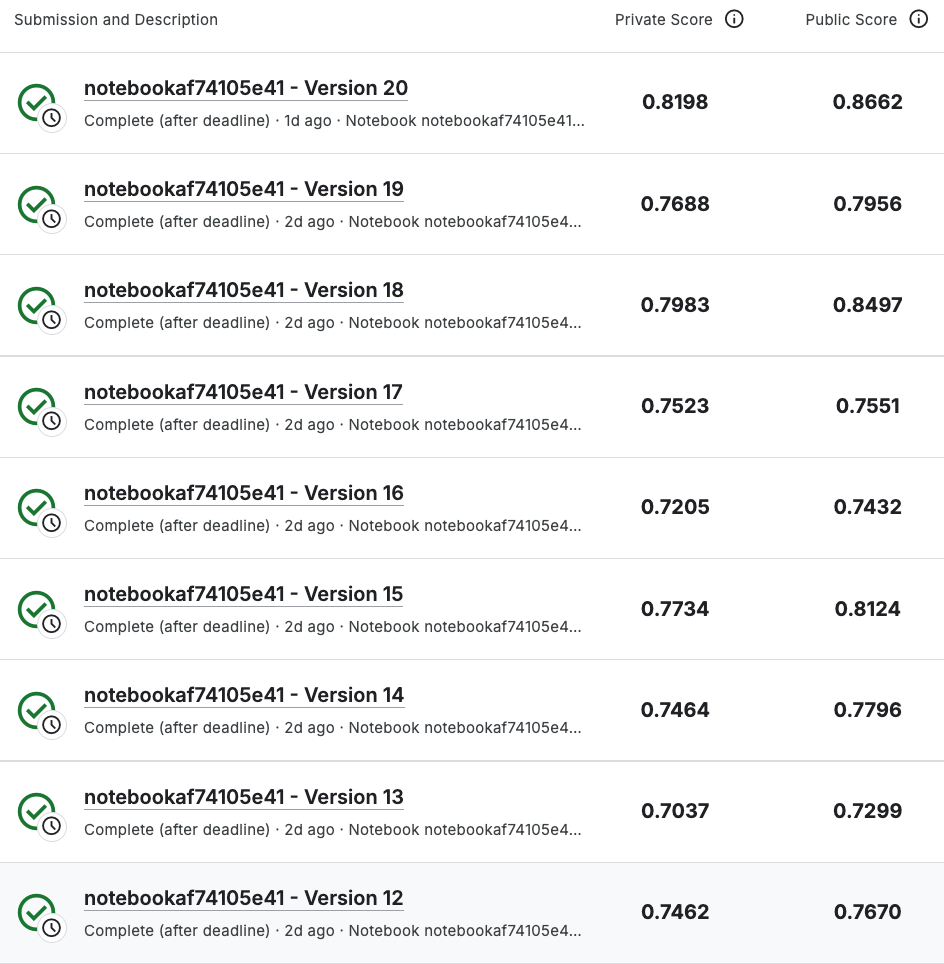
<figcaption>Figure 13: Kaggle Test Results Screenshot</figcaption>
</figure>

``` python
kaggle_df = kaggle_df.sort_index(ascending=False)
kaggle_df = kaggle_df.reset_index()
kaggle_df[['Kaggle Version', 'Kaggle Public Score', 'Model Family', "Image Dims [Px]"]]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | Kaggle Version | Kaggle Public Score | Model Family | Image Dims \[Px\] |
|-----|----------------|---------------------|--------------|-------------------|
| 0   | 20             | 0.8682              | ResNet       | 96                |
| 1   | 19             | 0.8163              | InceptionNet | 96                |
| 2   | 18             | 0.8497              | VGNet        | 96                |
| 3   | 17             | 0.7551              | ResNet       | 48                |
| 4   | 16             | 0.7432              | InceptionNet | 48                |
| 5   | 15             | 0.8124              | VGNet        | 48                |
| 6   | 14             | 0.7796              | ResNet       | 32                |
| 7   | 13             | 0.7299              | InceptionNet | 32                |
| 8   | 12             | 0.7670              | VGNet        | 32                |

</div>

Table 14: Kaggle Test Results

## 5.4 Kaggle Public Scores

``` python
plt.figure(figsize=(8, 3.5))

# Create the barplot
ax = sns.barplot(
    data=kaggle_df,
    x="Model Family",
    y="Kaggle Public Score",
    hue="Image Dims [Px]",
    palette=sns.color_palette()[:3]
);

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f")  # Format to 1 decimal place

# Move the legend below the x-axis
plt.legend(
    title="Image Dims [Px]",
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.2),  # Position legend below the x-axis
    ncol=3  # Arrange legend items in 3 columns
)

plt.xlabel(None)
plt.ylim((0, 1))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
```

<figure id="fig-submit-public-score">
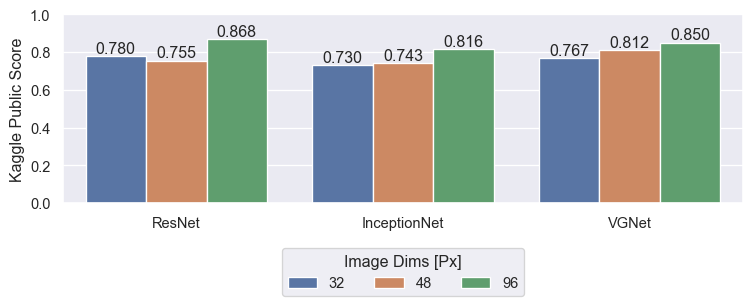
<figcaption>Figure 14: All Kaggle Submission Public Stores</figcaption>
</figure>

In [27]:
public_df = kaggle_df[['Model Family', "Image Dims [Px]", 'Kaggle Public Score', ]]
public_df = public_df.sort_values(['Kaggle Public Score'], ascending=False)
public_df = public_df.reset_index(drop=True)
public_df

<a href="#fig-submit-public-score" class="quarto-xref">Figure 14</a>,
and <a href="#tbl-public-results" class="quarto-xref">Table 15</a>
summarize the Kaggle public scores results for three model families
ResNet, VGNet, and InceptionNet, trained on images of varying dimensions
(32px, 48px, and 96px). Key observations include:

-   ResNet achieved the highest Kaggle public score (0.8682) when
    trained on 96px images, demonstrating the strongest performance on
    larger image sizes.
-   VGNet closely followed with a score of 0.8497 on 96px images and
    maintained competitive performance across all dimensions, ranking
    second overall with 48px images (0.8124) and third with 32px images
    (0.7670).
-   InceptionNet scored lower than both ResNet and VGNet across all
    image sizes, peaking at 0.8163 with 96px images and declining to
    0.7299 with 32px images.

Overall, larger image dimensions (96px) resulted in better public scores
for all models, with ResNet and VGNet consistently outperforming
InceptionNet across the board.

:::

## 5.5 Accuracy vs. Computational Efficiency

``` python
plt.figure(figsize=(8, 3.5))

# Create the barplot
ax = sns.barplot(
    data=kaggle_df,
    x="Model Family",
    y="Accuracy Per Training Hour",
    hue="Image Dims [Px]",
    palette=sns.color_palette()[:3]
);

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f")  # Format to 1 decimal place

# Move the legend below the x-axis
plt.legend(
    title="Image Dims [Px]",
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.2),  # Position legend below the x-axis
    ncol=3  # Arrange legend items in 3 columns
)

plt.xlabel(None)

# Adjust layout for better spacing
plt.ylim((0, 0.45))
plt.tight_layout()
plt.show()
```

<figure id="fig-submit-efficiency">
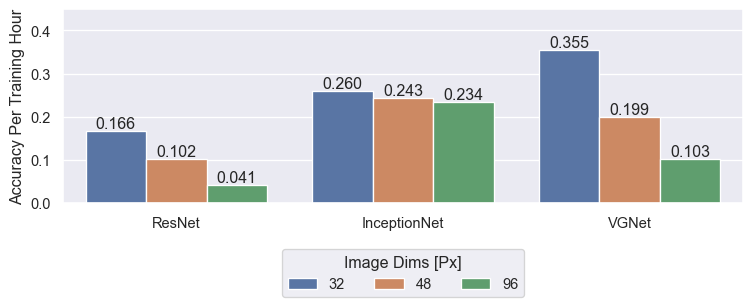
<figcaption>Figure 15: All Kaggle Submission Private Stores</figcaption>
</figure>

In [29]:
efficency_df = kaggle_df[['Model Family', "Image Dims [Px]", 'Accuracy Per Training Hour']]
efficency_df.loc[:, 'Accuracy Per Training Hour'] = efficency_df['Accuracy Per Training Hour'].round(3)
efficency_df = efficency_df.sort_values(['Accuracy Per Training Hour'], ascending=False)
efficency_df = efficency_df.reset_index(drop=True)
efficency_df

In <a href="#fig-submit-efficiency" class="quarto-xref">Figure 15</a>
and <a href="#tbl-efficency-results" class="quarto-xref">Table 16</a> we
detail the Accuracy Per Training Hour metric which evaluates model
efficiency by dividing the Kaggle public score by the training time. Key
findings include:

-   VGNet with 32px images achieves the highest efficiency (0.355),
    balancing accuracy with low training time.
-   InceptionNet also shows good efficiency at 32px (0.260), but its
    efficiency decreases with larger image sizes (48px: 0.243, 96px:
    0.234).
-   ResNet models are less efficient, with a significant drop in
    performance per training hour as image size increases (32px: 0.166,
    48px: 0.102, 96px: 0.041).

While accuracy is the primary metric, VGNet with 32px images offers the
best trade-off between accuracy and training efficiency, making it the
most suitable model when training time is a critical factor. In
contrast, ResNet shows diminishing returns in efficiency with larger
images, indicating higher computational cost relative to its accuracy
gains.

# 6. Conclusion

This project aimed to develop and evaluate a set of deep learning models
for image classification, leveraging various architectures including
VGNet, InceptionNet, and ResNet. The models were trained on image data
of varying resolutions (32px, 48px, 96px) to assess their performance
across different configurations. We conducted extensive training on
these models, carefully recording training times, accuracy scores, and
computational efficiency to identify the optimal balance between
accuracy and training cost.

Through systematic evaluation and comparison, we achieved a
comprehensive understanding of how different models and image sizes
affect both accuracy and training efficiency. The models were tested
using the Kaggle platform, and their performance was evaluated through
metrics such as public scores, training time, and efficiency per
training hour. This process provided valuable insights into which model
and image configurations offer the best trade-offs for the given task.

## 6.1 Achievements

The models trained on 96px images consistently outperformed those
trained on smaller images in terms of Kaggle public scores, with ResNet
96px achieving the highest score of 0.8682. However, when accounting for
the computational cost using the Accuracy Per Training Hour metric,
VGNet 32px emerged as the most efficient model, with the highest score
of 0.355. This highlights the importance of considering not just
accuracy but also the cost of training time when deploying machine
learning models in real-world scenarios.

The breadth of training included the evaluation of three different
architectures (VGNet, InceptionNet, ResNet) across multiple image sizes,
revealing critical patterns in model behavior, performance, and
computational efficiency. The depth of training involved extensive
epochs and rigorous testing, providing a reliable assessment of each
model’s ability to generalize to unseen data.

## 6.2 Future Work

Several areas of future work have the poential to further enhance these
cancer image detection accuracy and efficiency:

1.  Continued Hyperparameter Tuning:
    -   Stride and Padding: Experimenting with different stride values
        and padding techniques could help refine the model’s learning
        ability, especially for smaller image sizes, by adjusting how
        features are extracted during the convolutional layers.
    -   Leveraging hyperparamater optimization libraries including
        [Optuna](https://optuna.readthedocs.io/en/stable/)
2.  Training Rate Scheduling:
    -   Implementing dynamic learning rate scheduling methods (such as
        learning rate decay, cyclical learning rates, or one-cycle
        learning) could optimize convergence during training,
        potentially leading to better generalization and faster
        convergence.
3.  Early Stopping:
    -   Introducing early stopping based on validation loss could
        prevent overfitting, saving training time while ensuring the
        model generalizes well to new data.
4.  Image Normalization:
    -   Normalizing the input images using the measured dataset values
        (mean, standard deviation) could improve model stability and
        help accelerate convergence by reducing internal covariate
        shift.
5.  Data Augmentation:
    -   Experimenting with data augmentation techniques, such as
        jittering, rotations, or flipping, could increase model
        robustness by allowing it to learn from a wider variety of data
        representations and patterns.
6.  Model Ensembling:
    -   Further research could explore combining the predictions from
        multiple models using ensembling techniques (e.g., bagging or
        boosting) to improve predictive accuracy and reduce model bias.

By addressing these areas, future iterations of this project has the
potential produce models that are both more accurate and efficient, with
broader applicability across various image classification tasks.

# 7. References

Ansel, Jason, Edward Yang, Horace He, Natalia Gimelshein, Animesh Jain,
Michael Voznesensky, Bin Bao, et al. 2024. “<span class="nocase">PyTorch
2: Faster Machine Learning Through Dynamic Python Bytecode
Transformation and Graph Compilation</span>.” In *29th ACM International
Conference on Architectural Support for Programming Languages and
Operating Systems, Volume 2 (ASPLOS ’24)*. ACM.
<https://doi.org/10.1145/3620665.3640366>.

Cukierski, Will. 2018. “Histopathologic Cancer Detection.”
<https://kaggle.com/competitions/histopathologic-cancer-detection>.

He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. 2015. “Deep
Residual Learning for Image Recognition.”
<https://arxiv.org/abs/1512.03385>.

Simonyan, Karen, and Andrew Zisserman. 2015. “Very Deep Convolutional
Networks for Large-Scale Image Recognition.”
<https://arxiv.org/abs/1409.1556>.

Szegedy, Christian, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, and Andrew
Rabinovich. 2014. “Going Deeper with Convolutions.”
<https://arxiv.org/abs/1409.4842>.